### Importing necessary libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

C:\Users\vinay\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data loading and EDA

In [2]:
train_df=pd.read_csv('train.csv')
train_df.head()

id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [4]:
train_df[(train_df['NObeyesdad']!='Normal_Weight') & (train_df['NObeyesdad']!='Insufficient_Weight')]['family_history_with_overweight'].value_counts()

family_history_with_overweight
yes    14150
no      1003
Name: count, dtype: int64

In [5]:
train_df['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

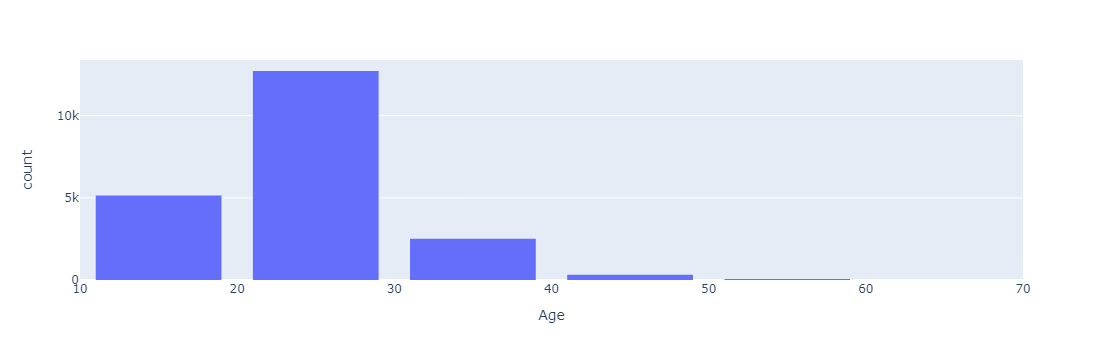

In [6]:
fig=px.histogram(train_df,train_df['Age'],nbins=5)
fig.update_layout(bargap=0.2)
fig.show()

Most of the people in our dataset are of the age between 20-30

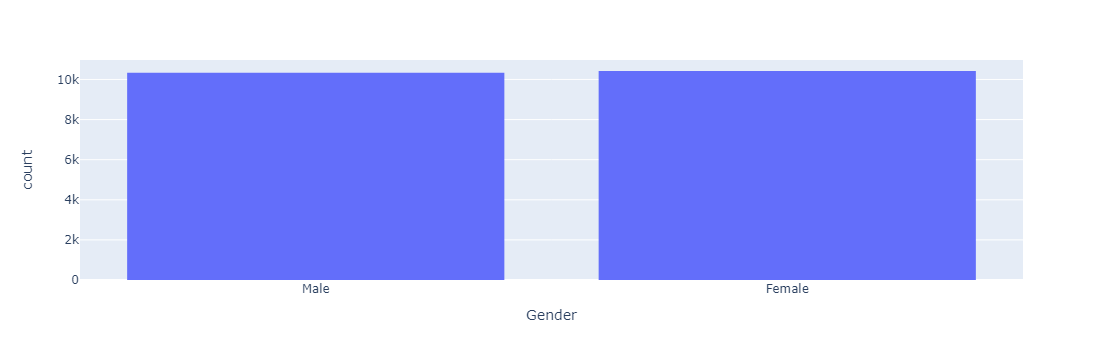

In [7]:
px.histogram(train_df,train_df['Gender'])

Gender distribution in the dataset is uniform across both categories

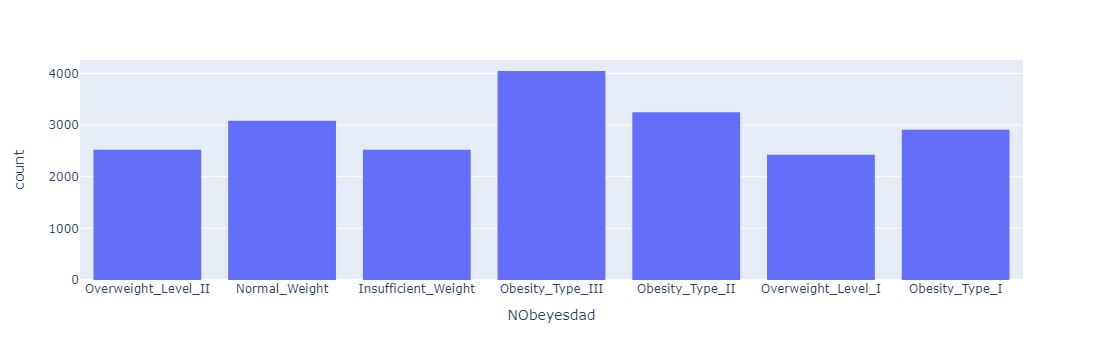

In [8]:
px.histogram(train_df,train_df['NObeyesdad'])

There is a slight imbalance between the classes in our dataset and it is necessary to handle this to prevent overfitting on any of the class

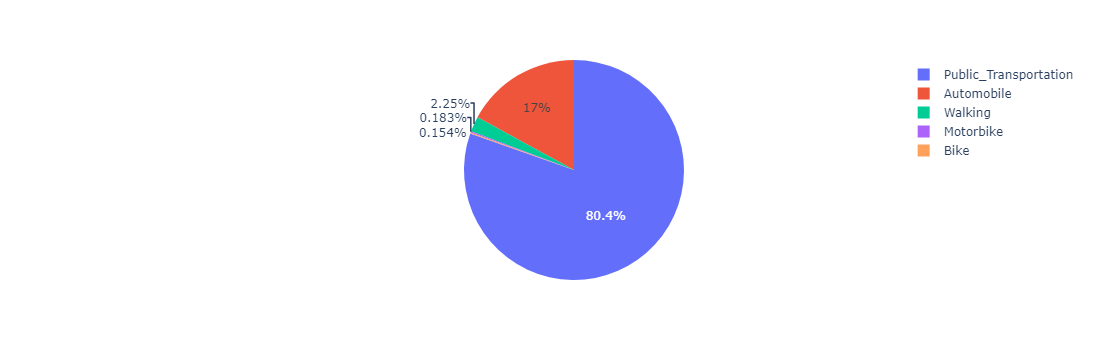

In [9]:
px.pie(train_df,names=train_df['MTRANS'].unique(),values=train_df['MTRANS'].value_counts().values)

Most of the people in our dataset prefer Public transportation as there primary means of transportation and percentage of people walking or using bike is very less.

In [10]:
train_df.groupby('NObeyesdad')['Age'].mean().reset_index()

NObeyesdad        Age
0  Insufficient_Weight  19.336502
1        Normal_Weight  20.801388
2       Obesity_Type_I  25.023615
3      Obesity_Type_II  27.707128
4     Obesity_Type_III  24.126847
5   Overweight_Level_I  23.045197
6  Overweight_Level_II  26.032084

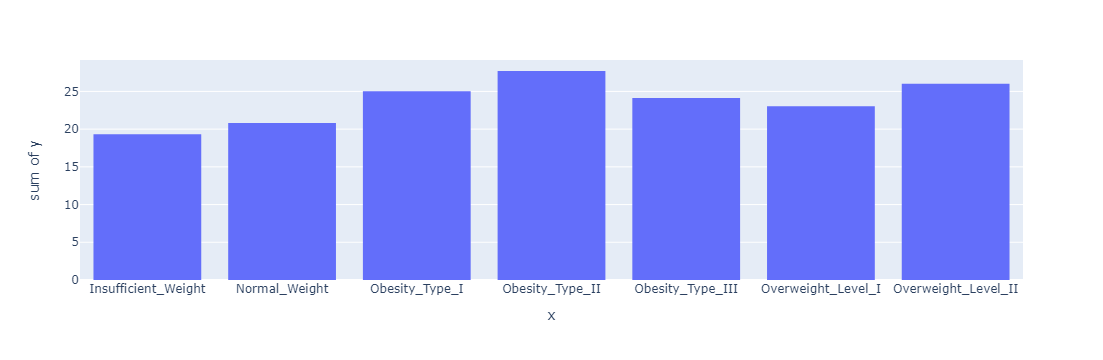

In [11]:
px.histogram(train_df.groupby('NObeyesdad')['Age'].mean().reset_index(),y=train_df.groupby('NObeyesdad')['Age'].mean().reset_index()['Age'],x=train_df.groupby('NObeyesdad')['Age'].mean().index,)

Mean age for each class

In [12]:
train_df['count']=1

In [13]:
trans_matrix=train_df[['NObeyesdad','MTRANS','count']].pivot_table(index='NObeyesdad', columns='MTRANS', aggfunc='sum', fill_value=0)


In [14]:
trans_matrix

count                                             
MTRANS              Automobile Bike Motorbike Public_Transportation Walking
NObeyesdad                                                                 
Insufficient_Weight        277    2         4                  2166      74
Normal_Weight              309   14        17                  2565     177
Obesity_Type_I             747    2         4                  2132      25
Obesity_Type_II            944    1         3                  2294       6
Obesity_Type_III             0    0         0                  4046       0
Overweight_Level_I         475    9         7                  1835     101
Overweight_Level_II        782    4         3                  1649      84

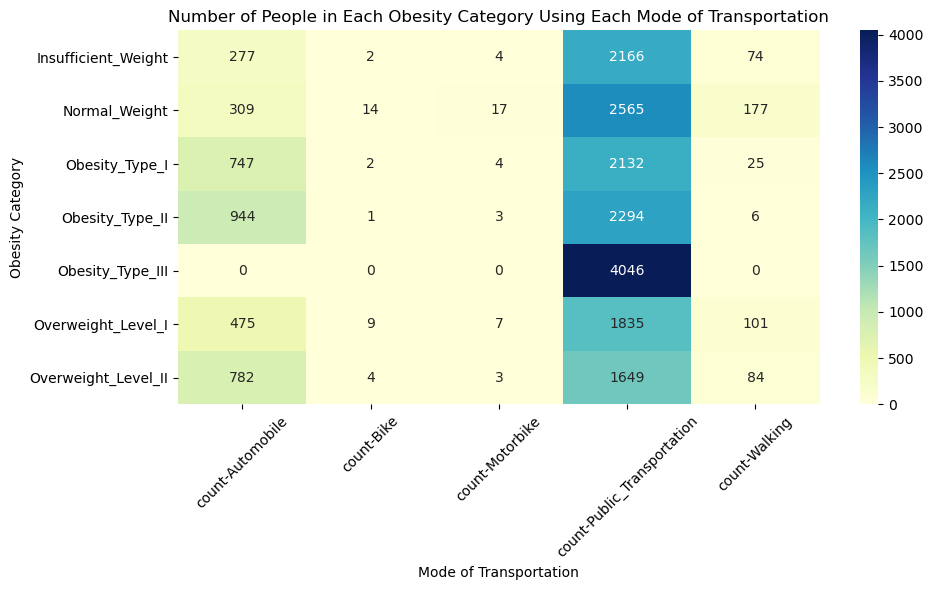

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(trans_matrix, annot=True, cmap="YlGnBu", fmt="g",)
plt.title('Number of People in Each Obesity Category Using Each Mode of Transportation')
plt.xlabel('Mode of Transportation')
plt.ylabel('Obesity Category')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

People having type III obesity dont prefer walking or using bike at all

In [16]:
train_df[train_df['Gender']=='Male']['NObeyesdad'].value_counts().index

Index(['Obesity_Type_II', 'Overweight_Level_II', 'Obesity_Type_I',
       'Normal_Weight', 'Overweight_Level_I', 'Insufficient_Weight',
       'Obesity_Type_III'],
      dtype='object', name='NObeyesdad')

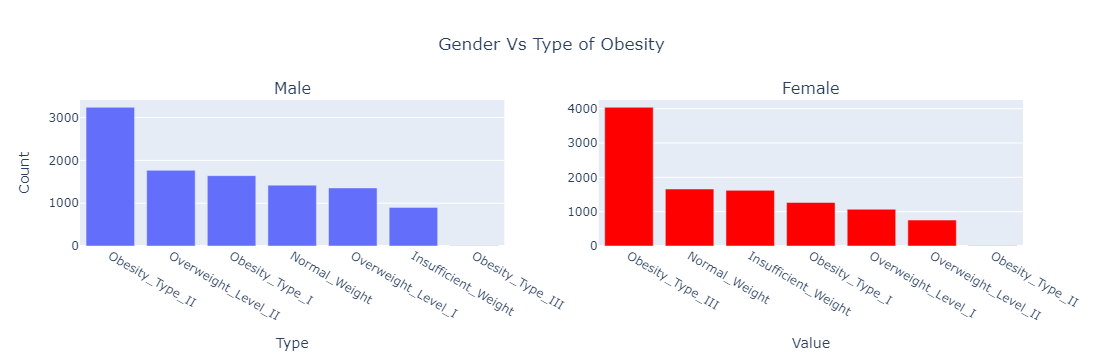

In [17]:
import plotly.subplots as sp
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Male', 'Female'))
fig.add_trace(px.bar(x=train_df[train_df['Gender']=='Male']['NObeyesdad'].value_counts().index,y=train_df[train_df['Gender']=='Male']['NObeyesdad'].value_counts().values).data[0], row=1, col=1)
fig.add_trace(px.bar(x=train_df[train_df['Gender']=='Female']['NObeyesdad'].value_counts().index,y=train_df[train_df['Gender']=='Female']['NObeyesdad'].value_counts().values,color_discrete_sequence=['red']).data[0], row=1, col=2)
fig.update_layout(
    title='Gender Vs Type of Obesity',
    xaxis_title='Type',
    yaxis_title='Count',
    title_x=0.5
)
fig.update_xaxes(title_text='Value', row=1, col=2,showticklabels=True)
# Ensure x-axis labels are displayed for the second histogram

fig.show()

Only females have Type III Obesity and only males have Type II obesity in our dataset

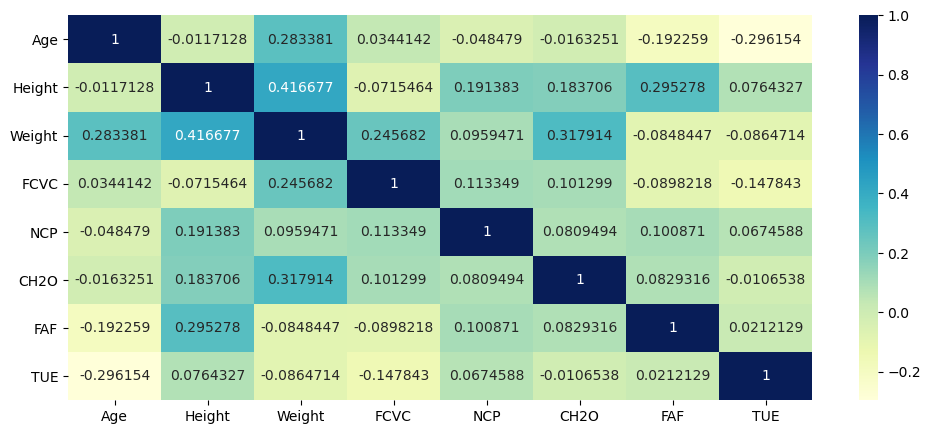

In [18]:
plt.figure(figsize=(12, 5))
sns.heatmap(train_df[['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']].corr(), annot=True, cmap="YlGnBu", fmt="g",)
plt.show()

### Data preprocessing

In [19]:
X=train_df.drop(columns=['id','count','NObeyesdad'])
y=train_df['NObeyesdad']
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(y)
y=le.transform(y)

In [20]:
for number, class_label in enumerate(le.classes_):
    print(f"{number} : {class_label}")

0 : Insufficient_Weight
1 : Normal_Weight
2 : Obesity_Type_I
3 : Obesity_Type_II
4 : Obesity_Type_III
5 : Overweight_Level_I
6 : Overweight_Level_II


In [21]:
y

array([6, 1, 0, ..., 3, 6, 3])

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,shuffle=True)#splitting data into training and validation

In [23]:
original_df=pd.read_csv('ObesityDataSet.csv')
original_df.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [24]:
original_df['NCP'].unique()

array([3.      , 1.      , 4.      , 3.28926 , 3.995147, 1.72626 ,
       2.581015, 1.600812, 1.73762 , 1.10548 , 2.0846  , 1.894384,
       2.857787, 3.765526, 3.285167, 3.691226, 3.156153, 1.07976 ,
       3.559841, 3.891994, 3.240578, 3.904858, 3.11158 , 3.590039,
       2.057935, 3.558637, 2.000986, 3.821168, 3.897078, 3.092116,
       3.286431, 3.592415, 3.754599, 3.566082, 3.725797, 3.520555,
       3.731212, 1.259803, 1.273128, 3.304123, 3.647154, 3.300666,
       3.535016, 1.717608, 2.884479, 3.626815, 1.473088, 3.16645 ,
       3.494849, 2.99321 , 2.127797, 3.90779 , 3.699594, 3.179995,
       1.075553, 3.238258, 3.804944, 1.630846, 3.762778, 3.371832,
       2.705445, 3.34175 , 2.217651, 2.893778, 3.502604, 3.998766,
       3.193671, 1.69608 , 2.812377, 1.612747, 1.082304, 1.882158,
       2.326233, 1.989398, 1.735493, 2.974568, 3.715118, 3.489918,
       3.378859, 3.263201, 3.994588, 3.24934 , 3.087544, 1.163666,
       3.409363, 3.281391, 3.98525 , 3.207071, 3.471536, 3.488

In [25]:
X_original=original_df.drop(columns=['NObeyesdad'])
y_original=original_df['NObeyesdad']
le=LabelEncoder()
le.fit(y_original)
y_original=le.transform(y_original)
y_original

array([1, 1, 1, ..., 4, 4, 4])

In [26]:
for number, class_label in enumerate(le.classes_):
    print(f"{number} : {class_label}")

0 : Insufficient_Weight
1 : Normal_Weight
2 : Obesity_Type_I
3 : Obesity_Type_II
4 : Obesity_Type_III
5 : Overweight_Level_I
6 : Overweight_Level_II


In [27]:
X_train_final=pd.concat([X_train,X_original])#adding original data to training dataset

In [28]:
y_train_final=np.concatenate([y_train,y_original])#adding original datalabels to training datalabels

In [29]:
temp_df=X_train_final.copy()
temp_df['target']=y_train_final

In [30]:
temp_df=temp_df.sample(frac=1)#shuffling the data so that all the original datapoints are not after the datapoints of our dataset

In [31]:
X_train_final=temp_df.drop(columns='target')
y_train_final=temp_df['target'].values

In [32]:
X_train_final.head()

Gender      Age    Height      Weight family_history_with_overweight  \
12193  Female  26.0000  1.641132  111.914361                            yes   
6036     Male  21.0000  1.780679   89.673648                            yes   
15549  Female  19.0000  1.660000   60.000000                            yes   
10822    Male  17.6739  1.710616   97.029249                            yes   
4274   Female  20.0000  1.560000   53.000000                             no   

      FAVC  FCVC  NCP        CAEC SMOKE      CH2O  SCC       FAF       TUE  \
12193  yes   3.0  3.0   Sometimes    no  2.737091   no  0.000000  0.071317   
6036   yes   2.0  1.0   Sometimes    no  3.000000   no  0.856119  1.000000   
15549  yes   1.0  3.0   Sometimes    no  1.000000  yes  0.000000  1.000000   
10822  yes   2.0  3.0   Sometimes    no  3.000000   no  1.000000  2.000000   
4274   yes   3.0  3.0  Frequently    no  2.000000  yes  1.000000  0.000000   

            CALC                 MTRANS  
12193  Sometimes  Public_Transportation  
6036   Sometimes  Public_Transportation  
15549  Sometimes  Public_Transportation  
10822         no  Public_Transportation  
4274   Sometimes  Public_Transportation

In [33]:
X_val.head()

Gender        Age    Height      Weight family_history_with_overweight  \
13496    Male  18.000000  1.814696  108.204547                            yes   
6851     Male  25.000000  1.840000   65.000000                            yes   
1298     Male  30.958051  1.750000  120.098812                            yes   
18520  Female  19.220108  1.528011   41.268597                             no   
793    Female  39.135634  1.643892   80.000000                            yes   

      FAVC      FCVC  NCP        CAEC SMOKE      CH2O SCC       FAF       TUE  \
13496  yes  2.000000  3.0   Sometimes    no  2.000000  no  0.880584  1.000000   
6851   yes  1.000000  3.0   Sometimes    no  2.000000  no  2.000000  0.000000   
1298   yes  2.156065  3.0   Sometimes    no  2.530035  no  1.042680  0.000000   
18520  yes  3.000000  1.0  Frequently    no  1.000000  no  0.000000  0.466169   
793    yes  2.000000  3.0   Sometimes    no  1.984323  no  1.299469  0.000000   

            CALC                 MTRANS  
13496  Sometimes  Public_Transportation  
6851   Sometimes  Public_Transportation  
1298   Sometimes  Public_Transportation  
18520  Sometimes  Public_Transportation  
793    Sometimes             Automobile

In [34]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC','CAEC', 'SMOKE','SCC', 'CALC', 'MTRANS']

In [35]:
X_train_ohe=pd.get_dummies(X_train_final, columns=categorical_features)#one hot encoding of categorical features

In [36]:
X_train_ohe.head()

Age    Height      Weight  FCVC  NCP      CH2O       FAF       TUE  \
12193  26.0000  1.641132  111.914361   3.0  3.0  2.737091  0.000000  0.071317   
6036   21.0000  1.780679   89.673648   2.0  1.0  3.000000  0.856119  1.000000   
15549  19.0000  1.660000   60.000000   1.0  3.0  1.000000  0.000000  1.000000   
10822  17.6739  1.710616   97.029249   2.0  3.0  3.000000  1.000000  2.000000   
4274   20.0000  1.560000   53.000000   3.0  3.0  2.000000  1.000000  0.000000   

       Gender_Female  Gender_Male  ...  SCC_yes  CALC_Always  CALC_Frequently  \
12193           True        False  ...    False        False            False   
6036           False         True  ...    False        False            False   
15549           True        False  ...     True        False            False   
10822          False         True  ...    False        False            False   
4274            True        False  ...     True        False            False   

       CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
12193            True    False              False        False   
6036             True    False              False        False   
15549            True    False              False        False   
10822           False     True              False        False   
4274             True    False              False        False   

       MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  
12193             False                          True           False  
6036              False                          True           False  
15549             False                          True           False  
10822             False                          True           False  
4274              False                          True           False  

[5 rows x 31 columns]

In [37]:
X_val_ohe=pd.get_dummies(X_val, columns=categorical_features)#one hot encoding of categorical features
X_val_ohe.head()

Age    Height      Weight      FCVC  NCP      CH2O       FAF  \
13496  18.000000  1.814696  108.204547  2.000000  3.0  2.000000  0.880584   
6851   25.000000  1.840000   65.000000  1.000000  3.0  2.000000  2.000000   
1298   30.958051  1.750000  120.098812  2.156065  3.0  2.530035  1.042680   
18520  19.220108  1.528011   41.268597  3.000000  1.0  1.000000  0.000000   
793    39.135634  1.643892   80.000000  2.000000  3.0  1.984323  1.299469   

            TUE  Gender_Female  Gender_Male  ...  SCC_no  SCC_yes  \
13496  1.000000          False         True  ...    True    False   
6851   0.000000          False         True  ...    True    False   
1298   0.000000          False         True  ...    True    False   
18520  0.466169           True        False  ...    True    False   
793    0.000000           True        False  ...    True    False   

       CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  \
13496            False            True    False              False   
6851             False            True    False              False   
1298             False            True    False              False   
18520            False            True    False              False   
793              False            True    False               True   

       MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
13496        False             False                          True   
6851         False             False                          True   
1298         False             False                          True   
18520        False             False                          True   
793          False             False                         False   

       MTRANS_Walking  
13496           False  
6851            False  
1298            False  
18520           False  
793             False  

[5 rows x 30 columns]

In [38]:
#Perform scaling to bring all numerical columns to one scale
numerical_columns=['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
from sklearn.preprocessing import StandardScaler
for c in numerical_columns:
    ss=StandardScaler()
    X_train_ohe[[c]]=ss.fit_transform(X_train_ohe[[c]])

In [39]:
X_train_ohe.head()

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
12193  0.370656 -0.670841  0.918385  1.045634  0.347134  1.166819 -1.172221   
6036  -0.501852  0.912541  0.074396 -0.831179 -2.452927  1.597526 -0.150783   
15549 -0.850855 -0.456754 -1.051657 -2.707992  0.347134 -1.678947 -1.172221   
10822 -1.082262  0.117565  0.353526 -0.831179  0.347134  1.597526  0.020882   
4274  -0.676354 -1.591412 -1.317292  1.045634  0.347134 -0.040710  0.020882   

            TUE  Gender_Female  Gender_Male  ...  SCC_yes  CALC_Always  \
12193 -0.914138           True        False  ...    False        False   
6036   0.625812          False         True  ...    False        False   
15549  0.625812           True        False  ...     True        False   
10822  2.284021          False         True  ...    False        False   
4274  -1.032396           True        False  ...     True        False   

       CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  \
12193            False            True    False              False   
6036             False            True    False              False   
15549            False            True    False              False   
10822            False           False     True              False   
4274             False            True    False              False   

       MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
12193        False             False                          True   
6036         False             False                          True   
15549        False             False                          True   
10822        False             False                          True   
4274         False             False                          True   

       MTRANS_Walking  
12193           False  
6036            False  
15549           False  
10822           False  
4274            False  

[5 rows x 31 columns]

In [40]:
#Perform scaling to bring all numerical columns to one scale
for c in numerical_columns:
    ss=StandardScaler()
    X_val_ohe[[c]]=ss.fit_transform(X_val_ohe[[c]])
X_val_ohe.head()

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
13496 -1.012488  1.311783  0.764390 -0.832707  0.333577 -0.065014 -0.132855   
6851   0.183217  1.603549 -0.871205 -2.699938  0.333577 -0.065014  1.191559   
1298   1.200942  0.565809  1.214671 -0.541298  0.333577  0.815698  0.058925   
18520 -0.804075 -1.993824 -1.769605  1.034524 -2.501442 -1.726625 -1.174700   
793    2.597796 -0.657664 -0.303350 -0.832707  0.333577 -0.091063  0.362740   

            TUE  Gender_Female  Gender_Male  ...  SCC_no  SCC_yes  \
13496  0.645917          False         True  ...    True    False   
6851  -1.015930          False         True  ...    True    False   
1298  -1.015930          False         True  ...    True    False   
18520 -0.241229           True        False  ...    True    False   
793   -1.015930           True        False  ...    True    False   

       CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  \
13496            False            True    False              False   
6851             False            True    False              False   
1298             False            True    False              False   
18520            False            True    False              False   
793              False            True    False               True   

       MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
13496        False             False                          True   
6851         False             False                          True   
1298         False             False                          True   
18520        False             False                          True   
793          False             False                         False   

       MTRANS_Walking  
13496           False  
6851            False  
1298            False  
18520           False  
793             False  

[5 rows x 30 columns]

In [41]:
X_val_ohe['CALC_Always']=False

In [42]:
X_val_ohe=X_val_ohe[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no', 'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']]

In [43]:
X_val_ohe.head()

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
13496 -1.012488  1.311783  0.764390 -0.832707  0.333577 -0.065014 -0.132855   
6851   0.183217  1.603549 -0.871205 -2.699938  0.333577 -0.065014  1.191559   
1298   1.200942  0.565809  1.214671 -0.541298  0.333577  0.815698  0.058925   
18520 -0.804075 -1.993824 -1.769605  1.034524 -2.501442 -1.726625 -1.174700   
793    2.597796 -0.657664 -0.303350 -0.832707  0.333577 -0.091063  0.362740   

            TUE  Gender_Female  Gender_Male  ...  SCC_yes  CALC_Always  \
13496  0.645917          False         True  ...    False        False   
6851  -1.015930          False         True  ...    False        False   
1298  -1.015930          False         True  ...    False        False   
18520 -0.241229           True        False  ...    False        False   
793   -1.015930           True        False  ...    False        False   

       CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  \
13496            False            True    False              False   
6851             False            True    False              False   
1298             False            True    False              False   
18520            False            True    False              False   
793              False            True    False               True   

       MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
13496        False             False                          True   
6851         False             False                          True   
1298         False             False                          True   
18520        False             False                          True   
793          False             False                         False   

       MTRANS_Walking  
13496           False  
6851            False  
1298            False  
18520           False  
793             False  

[5 rows x 31 columns]

## Model building

### Hyper parameter tuning for XGboost

In [44]:
# from sklearn.model_selection import StratifiedKFold
# stratified_kfold=StratifiedKFold(5,shuffle=True,random_state=42)
# def objective(trial):
#     trial_number=trial.number
#     print(f'Trial{trial_number+1} in progress')
#     params={
#         'booster':'gbtree',
#         'objective':'multi:softmax',
#         'num_class':7,
#         'eval_metric':'merror',
#         'n_estimators':trial.suggest_int('n_estimators',100,300),
#         'min_split_loss':trial.suggest_float('min_split_loss',1e-9,0.5),
#         'learning_rate':trial.suggest_float('learning_rate',0.01,1.0,log=True),
#         'max_depth':trial.suggest_int('max_depth',3,10),
#         'subsample':trial.suggest_float('subsample',0.3,1),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.3,1),
#         'min_child_weight':trial.suggest_int('min_child_weight',1,10),
#         'reg_lambda':trial.suggest_float('reg_lambda',1e-9,100.0,log=True),
#         'reg_alpha':trial.suggest_float('reg_alpha',1e-9,100.0,log=True)
#     }
#     xgbc=XGBClassifier(**params)
#     scores=cross_val_score(estimator=xgbc,X=X_train_ohe,y=y_train_final,scoring='accuracy',cv=stratified_kfold)
#     accuracy=np.mean(scores)
#     return accuracy
# study=optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=400)
# trial=study.best_trial
# print(f"Best accuracy: {trial.value}")
# print(f"Best hyperparameters: {trial.params}")

# best_params = {
#     'booster': 'gbtree',
#     'objective': 'multi:softmax',
#     'num_class': 7,
#     'eval_metric': 'merror',
#     'n_estimators': trial.params['n_estimators'],
#     'min_split_loss': trial.params['min_split_loss'],
#     'learning_rate': trial.params['learning_rate'],
#     'max_depth': trial.params['max_depth'],
#     'subsample': trial.params['subsample'],
#     'colsample_bytree': trial.params['colsample_bytree'],
#     'min_child_weight': trial.params['min_child_weight'],
#     'reg_lambda': trial.params['reg_lambda'],
#     'reg_alpha': trial.params['reg_alpha']
# }

In [45]:
# optuna.visualization.plot_optimization_history(study)

In [46]:
# optuna.visualization.plot_param_importances(study)

In [47]:
# optuna.visualization.plot_slice(study)

In [48]:
#best parameters obtained
best_params={'n_estimators': 300, 'min_split_loss': 0.04518476297249134, 'learning_rate': 0.05087692540918642, 'max_depth': 7, 'subsample': 0.7610295567805756, 'colsample_bytree': 0.5176876044286947, 'min_child_weight': 5, 'reg_lambda': 4.059262523615098e-07, 'reg_alpha': 1.3972366932053846,'class_weight':'balanced'}

In [49]:
#Training
xgbc=XGBClassifier(**best_params)
xgbc.fit(X_train_ohe,y_train_final)

[20:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5176876044286947,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05087692540918642,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, min_split_loss=0.04518476297249134,
              missing=nan, monotone_constraints=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

### Optimizing probability threshold for each class using optuna

In [50]:
run_optuna_threshold=True
threshold_optimization=True
y_predproba_xgb_val=xgbc.predict_proba(X_val_ohe)
y_predproba_xgb_train=xgbc.predict_proba(X_train_ohe)
def objective(trial):

    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    y_pred = apply_thresholds(y_pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy  

def apply_thresholds(y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

In [51]:
if run_optuna_threshold : 
    num_classes = 7
    y_pred_proba = y_predproba_xgb_val  # Example: replace with actual y_pred_proba
    y_val = y_val # Example: replace with actual y_val

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)

    # Get the best thresholds
    best_thresholds = study.best_params
    print("Best Thresholds:", best_thresholds)
    print("Best Value:", study.best_value)
    threshold_optimization = True

if threshold_optimization :
    best_y_pred_xgbc_val = apply_thresholds(y_predproba_xgb_val, best_thresholds)
    best_y_pred_xgbc_train = apply_thresholds(y_predproba_xgb_train, best_thresholds)

[I 2024-05-04 20:58:43,922] A new study created in memory with name: no-name-41d6383e-f75c-45a5-a522-c80946cae77d
C:\Users\vinay\AppData\Local\Temp\ipykernel_3996\3210461827.py:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-05-04 20:58:43,927] Trial 0 finished with value: 0.7976878612716763 and parameters: {'threshold_0': 0.8007864158860741, 'threshold_1': 0.10753370517126182, 'threshold_2': 0.726497974083878, 'threshold_3': 0.8358298339181026, 'threshold_4': 0.5590919559527475, 'threshold_5': 0.6588492261640556, 'threshold_6': 0.6542951981282806}. Best is trial 0 with value: 0.7976878612716763.
C:\Users\vinay\AppData\Local\Temp\ipykernel_3996\3210461827.py:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Best Thresholds: {'threshold_0': 0.745415327198789, 'threshold_1': 0.029052146522618782, 'threshold_2': 0.797063714361381, 'threshold_3': 0.5831504516456326, 'threshold_4': 0.05710347634862735, 'threshold_5': 0.975759679265546, 'threshold_6': 0.9658782923969649}
Best Value: 0.9000481695568401


In [52]:
#Appending the predictions of XGBoost to training and validation dataset
X_train_ohe['XGB']=best_y_pred_xgbc_train
X_val_ohe['XGB']=best_y_pred_xgbc_val

### XGBoost model performance 

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       492
           1       0.85      0.86      0.86       639
           2       0.89      0.89      0.89       553
           3       0.97      0.97      0.97       660
           4       1.00      0.98      0.99       825
           5       0.80      0.73      0.77       486
           6       0.80      0.84      0.82       497

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152

Accuracy is:  0.9000481695568401


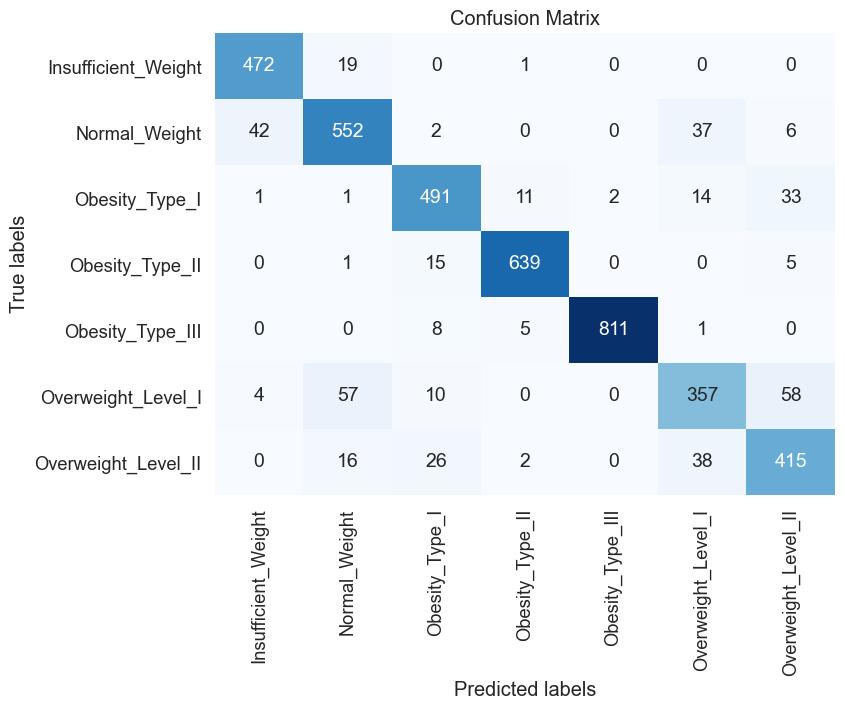

In [94]:
cr=classification_report(y_val,best_y_pred_xgbc_val)
print(cr)
accuracy=accuracy_score(y_val,best_y_pred_xgbc_val)
print('Accuracy is: ',accuracy)
cf=confusion_matrix(y_val,best_y_pred_xgbc_val)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, cbar=False,xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

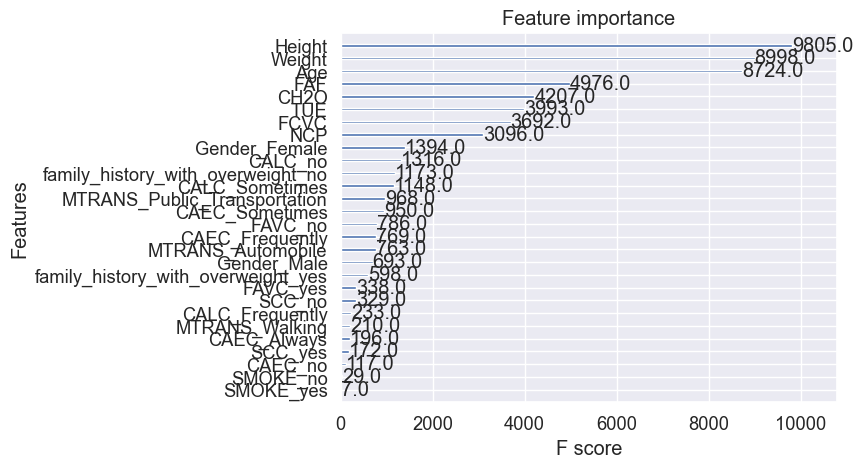

<Figure size 10000x10000 with 0 Axes>

In [54]:
from xgboost import plot_importance
plot_importance(xgbc, importance_type='weight')
plt.figure(figsize=(100, 100))
plt.show()

### Making predictions for test dataset using XGBoost

In [55]:
test_df=pd.read_csv('test.csv')
test_df.head()

id  Gender        Age    Height      Weight  \
0  20758    Male  26.899886  1.848294  120.644178   
1  20759  Female  21.000000  1.600000   66.000000   
2  20760  Female  26.000000  1.643355  111.600553   
3  20761    Male  20.979254  1.553127  103.669116   
4  20762  Female  26.000000  1.627396  104.835346   

  family_history_with_overweight FAVC      FCVC       NCP       CAEC SMOKE  \
0                            yes  yes  2.938616  3.000000  Sometimes    no   
1                            yes  yes  2.000000  1.000000  Sometimes    no   
2                            yes  yes  3.000000  3.000000  Sometimes    no   
3                            yes  yes  2.000000  2.977909  Sometimes    no   
4                            yes  yes  3.000000  3.000000  Sometimes    no   

       CH2O SCC       FAF       TUE       CALC                 MTRANS  
0  2.825629  no  0.855400  0.000000  Sometimes  Public_Transportation  
1  3.000000  no  1.000000  0.000000  Sometimes  Public_Transportation  
2  2.621877  no  0.000000  0.250502  Sometimes  Public_Transportation  
3  2.786417  no  0.094851  0.000000  Sometimes  Public_Transportation  
4  2.653531  no  0.000000  0.741069  Sometimes  Public_Transportation

In [56]:
test_df_ohe=pd.get_dummies(test_df, columns=categorical_features)

In [57]:
numerical_columns=['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
from sklearn.preprocessing import StandardScaler
for c in numerical_columns:
    ss=StandardScaler()
    test_df_ohe[[c]]=ss.fit_transform(test_df_ohe[[c]])

In [58]:
test_predproba_xbgc=xgbc.predict_proba(test_df_ohe.drop(columns=['id']))
best_y_pred_xgbc_test = apply_thresholds(test_predproba_xbgc, best_thresholds)
best_y_pred_xgbc_test=le.inverse_transform(best_y_pred_xgbc_test)

In [59]:
submission=test_df_ohe['id'].reset_index()
submission['NObeyesdad']=best_y_pred_xgbc_test

In [60]:
submission_xgb=submission.set_index('id').drop(columns=['index'])

In [61]:
submission_xgb.to_csv('xgb.csv')

### Hyperparameter tuning for LGBM

In [62]:
# from sklearn.model_selection import StratifiedKFold
# stratified_kfold=StratifiedKFold(5,shuffle=True,random_state=42)
# def objective(trial):
#     trial_number = trial.number
#     print(f'Trial {trial_number + 1} in progress')
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 42,
#         "num_class": 7,
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
#         "n_estimators": trial.suggest_int("n_estimators", 400, 600),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
#         "max_depth": trial.suggest_int("max_depth", 6, 14),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#         "subsample": trial.suggest_float("subsample", 0.8, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 10, 50)
#     }
#     lgbm_classifier = LGBMClassifier(**param)
#     scores = cross_val_score(estimator=lgbm_classifier, X=X_train_ohe, y=y_train_final, scoring='accuracy', cv=stratified_kfold)
#     accuracy = np.mean(scores)
#     return accuracy
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction='maximize',sampler=sampler)
# study.optimize(objective, n_trials=400)
# trial = study.best_trial
# print(f"Best accuracy: {trial.value}")
# print(f"Best hyperparameters: {trial.params}")

# best_params_lgbm = {
#     'objective': 'multiclass',
#     'num_class': 7,
#     'metric': 'multi_logloss',
#     'boosting_type': 'gbdt',
#     'random_state': 42,
#     'learning_rate': trial.params['learning_rate'],
#     'n_estimators': trial.params['n_estimators'],
#     'lambda_l1': trial.params['lambda_l1'],
#     'lambda_l2': trial.params['lambda_l2'],
#     'max_depth': trial.params['max_depth'],
#     'colsample_bytree': trial.params['colsample_bytree'],
#     'subsample': trial.params['subsample'],
#     'min_child_samples': trial.params['min_child_samples']
# }

In [63]:
#best parameters obtained
params_lgbm = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 7,
    'learning_rate': 0.011608862351698536,
    'n_estimators': 409,
    'max_depth': 6,
    'colsample_bytree': 0.6620129953824786,
    'subsample': 0.8301686394250093,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0006736855911107503,  
    'lambda_l2':  7.440526925966213,   
    'num_leaves': 23,    
    'feature_fraction': 0.9721415338635125,  
    'bagging_fraction': 0.4074895053692709,  
    'bagging_freq': 6,    
    'min_child_samples': 96,
    'class_weights':'balanced'
}

In [64]:
# Training the model
from lightgbm import LGBMClassifier
lgbm_c=LGBMClassifier(**params_lgbm)
lgbm_c.fit(X_train_ohe.drop(columns=['XGB']),y_train_final)

[LightGBM] [Warning] Unknown parameter: class_weights
[LightGBM] [Warning] feature_fraction is set=0.9721415338635125, colsample_bytree=0.6620129953824786 will be ignored. Current value: feature_fraction=0.9721415338635125
[LightGBM] [Warning] lambda_l1 is set=0.0006736855911107503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006736855911107503
[LightGBM] [Warning] lambda_l2 is set=7.440526925966213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.440526925966213
[LightGBM] [Warning] bagging_fraction is set=0.4074895053692709, subsample=0.8301686394250093 will be ignored. Current value: bagging_fraction=0.4074895053692709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Unknown parameter: class_weights
[LightGBM] [Warning] feature_fraction is set=0.9721415338635125, colsample_bytree=0.6620129953824786 will be ignored. Current value: feature_fraction=0.9721415338635125
[LightGBM] [W

LGBMClassifier(bagging_fraction=0.4074895053692709, bagging_freq=6,
               class_weights='balanced', colsample_bytree=0.6620129953824786,
               feature_fraction=0.9721415338635125,
               lambda_l1=0.0006736855911107503, lambda_l2=7.440526925966213,
               learning_rate=0.011608862351698536, max_depth=6,
               metric='multi_logloss', min_child_samples=96, n_estimators=409,
               num_class=7, num_leaves=23, objective='multiclass',
               subsample=0.8301686394250093)

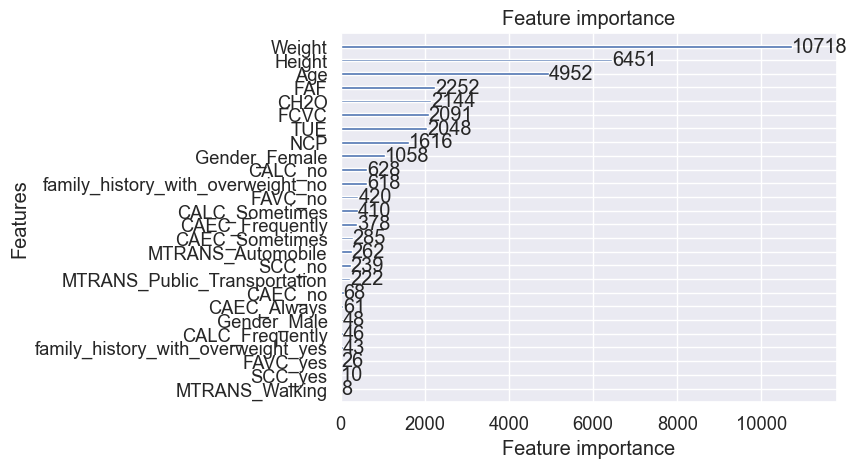

<Figure size 1000x50000 with 0 Axes>

In [65]:
#Plotting feature importance
from lightgbm import plot_importance
plot_importance(lgbm_c)
plt.figure(figsize=(10, 500))
plt.tight_layout() 
plt.show()

### Optimizing probability threshold for each class using optuna

In [66]:
run_optuna_threshold=True
threshold_optimization=True
y_predproba_lgbm_val=lgbm_c.predict_proba(X_val_ohe.drop(columns=['XGB']))
y_predproba_lgbm_train=lgbm_c.predict_proba(X_train_ohe.drop(columns=['XGB']))
def objective(trial):

    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    y_pred = apply_thresholds(y_pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy  

def apply_thresholds(y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

[LightGBM] [Warning] Unknown parameter: class_weights
[LightGBM] [Warning] feature_fraction is set=0.9721415338635125, colsample_bytree=0.6620129953824786 will be ignored. Current value: feature_fraction=0.9721415338635125
[LightGBM] [Warning] lambda_l1 is set=0.0006736855911107503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006736855911107503
[LightGBM] [Warning] lambda_l2 is set=7.440526925966213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.440526925966213
[LightGBM] [Warning] bagging_fraction is set=0.4074895053692709, subsample=0.8301686394250093 will be ignored. Current value: bagging_fraction=0.4074895053692709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Unknown parameter: class_weights
[LightGBM] [Warning] feature_fraction is set=0.9721415338635125, colsample_bytree=0.6620129953824786 will be ignored. Current value: feature_fraction=0.9721415338635125
[LightGBM] [W

In [67]:
if run_optuna_threshold : 
    num_classes = 7
    y_pred_proba = y_predproba_lgbm_val  # Example: replace with actual y_pred_proba
    y_val = y_val # Example: replace with actual y_val

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)

    # Get the best thresholds
    best_thresholds_lgbm = study.best_params
    print("Best Thresholds:", best_thresholds)
    print("Best Value:", study.best_value)
    threshold_optimization = True

if threshold_optimization :
    best_y_pred_lgbm_val = apply_thresholds(y_predproba_lgbm_val, best_thresholds_lgbm)
    best_y_pred_lgbm_train = apply_thresholds(y_predproba_lgbm_train, best_thresholds_lgbm)

[I 2024-05-04 20:59:03,362] A new study created in memory with name: no-name-91fc370d-1395-43b8-86ca-c492a780c9f0
C:\Users\vinay\AppData\Local\Temp\ipykernel_3996\3512166650.py:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-05-04 20:59:03,368] Trial 0 finished with value: 0.6575144508670521 and parameters: {'threshold_0': 0.14098075853203107, 'threshold_1': 0.10694886970060424, 'threshold_2': 0.025914652322660325, 'threshold_3': 0.8576161739187274, 'threshold_4': 0.022137087521991283, 'threshold_5': 0.016675665039639798, 'threshold_6': 0.6345159501568769}. Best is trial 0 with value: 0.6575144508670521.
C:\Users\vinay\AppData\Local\Temp\ipykernel_3996\3512166650.py:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

Best Thresholds: {'threshold_0': 0.745415327198789, 'threshold_1': 0.029052146522618782, 'threshold_2': 0.797063714361381, 'threshold_3': 0.5831504516456326, 'threshold_4': 0.05710347634862735, 'threshold_5': 0.975759679265546, 'threshold_6': 0.9658782923969649}
Best Value: 0.8928227360308285


In [68]:
#Adding predicitons made my LGBM to train and validation dataset
X_train_ohe['LGBM']=best_y_pred_lgbm_train
X_val_ohe['LGBM']=best_y_pred_lgbm_val

### LGBM model performance 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       492
           1       0.86      0.83      0.84       639
           2       0.88      0.89      0.88       553
           3       0.97      0.96      0.96       660
           4       0.99      1.00      0.99       825
           5       0.77      0.75      0.76       486
           6       0.80      0.81      0.81       497

    accuracy                           0.89      4152
   macro avg       0.88      0.88      0.88      4152
weighted avg       0.89      0.89      0.89      4152

Accuracy is:  0.8928227360308285


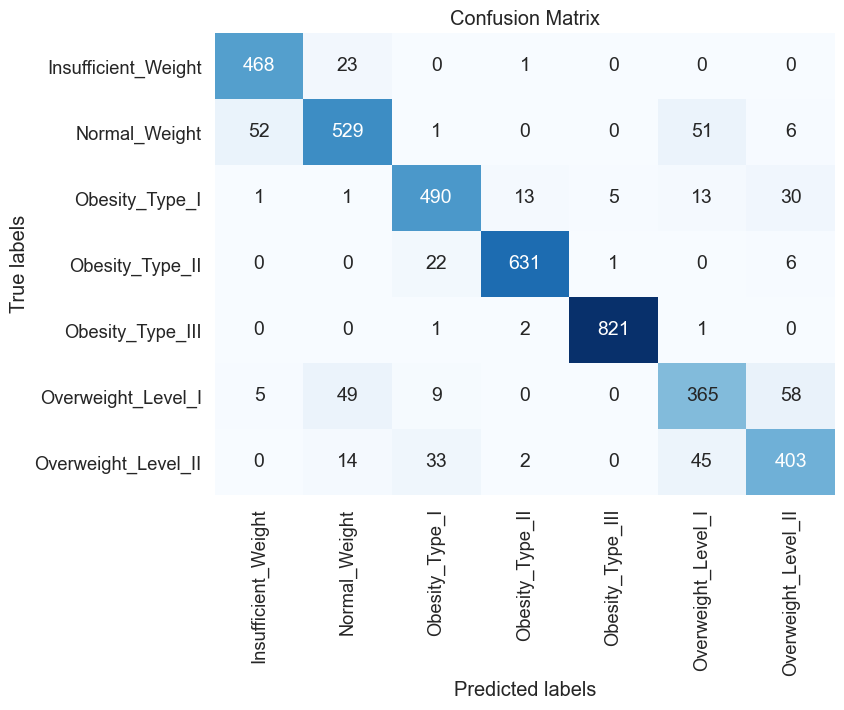

In [95]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
cr=classification_report(y_val,best_y_pred_lgbm_val)
print(cr)
accuracy=accuracy_score(y_val,best_y_pred_lgbm_val)
print('Accuracy is: ',accuracy)
cf=confusion_matrix(y_val,best_y_pred_lgbm_val)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, cbar=False,xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Making predictions for test dataset using LGBM

In [70]:
test_predproba_lgbm=lgbm_c.predict_proba(test_df_ohe.drop(columns=['id']))
best_y_pred_lgbm_test = apply_thresholds(test_predproba_lgbm, best_thresholds_lgbm)
best_y_pred_lgbm_test=le.inverse_transform(best_y_pred_lgbm_test)
submission_lgbm=test_df_ohe['id'].reset_index()
submission_lgbm['NObeyesdad']=best_y_pred_lgbm_test
submission_lgbm=submission.set_index('id').drop(columns=['index'])
submission_lgbm.to_csv('sub_lgbm.csv')

[LightGBM] [Warning] Unknown parameter: class_weights
[LightGBM] [Warning] feature_fraction is set=0.9721415338635125, colsample_bytree=0.6620129953824786 will be ignored. Current value: feature_fraction=0.9721415338635125
[LightGBM] [Warning] lambda_l1 is set=0.0006736855911107503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006736855911107503
[LightGBM] [Warning] lambda_l2 is set=7.440526925966213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.440526925966213
[LightGBM] [Warning] bagging_fraction is set=0.4074895053692709, subsample=0.8301686394250093 will be ignored. Current value: bagging_fraction=0.4074895053692709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [71]:
submission_lgbm

NObeyesdad
id                        
20758      Obesity_Type_II
20759   Overweight_Level_I
20760     Obesity_Type_III
20761       Obesity_Type_I
20762     Obesity_Type_III
...                    ...
34593  Overweight_Level_II
34594        Normal_Weight
34595  Insufficient_Weight
34596        Normal_Weight
34597      Obesity_Type_II

[13840 rows x 1 columns]

### Hyperparameter tuning for logistic regression

In [72]:
# from sklearn.model_selection import StratifiedKFold
# stratified_kfold=StratifiedKFold(5,shuffle=True,random_state=42)
# def objective(trial):
#     trial_number=trial.number
#     print(f'Trial{trial_number+1} in progress')
#     params={
#         'penalty':'l2',
#         'dual':False,
#         'tol':trial.suggest_float('tol',1e-6,1e-2),
#         'C':trial.suggest_float('C',1e-1,10),
#         'fit_intercept':True,
#         'intercept_scaling':1,
#         'class_weight':'balanced',
#         'random_state':None,
#         'solver':trial.suggest_categorical('solver',['lbfgs', 'newton-cg', 'sag', 'saga']),
#         'multi_class':'multinomial',
#         'verbose':0,
#         'warm_start':False,
#         'n_jobs':-1,
#         'l1_ratio':None
#     }
#     logreg=LogisticRegression(**params)
#     scores=cross_val_score(estimator=logreg,X=X_train_ohe,y=y_train_final,scoring='accuracy',cv=stratified_kfold)
#     accuracy=np.mean(scores)
#     return accuracy
# study=optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=100,)
# trial=study.best_trial
# print(f"Best accuracy: {trial.value}")
# print(f"Best hyperparameters: {trial.params}")


In [73]:
# Best parameters obtained
logreg_params={'penalty': 'l2',
 'dual': False,
 'tol': 0.0017018624286953311,
 'C': 9.465840240882544,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': 'balanced',
 'random_state': None,
 'solver': 'sag',
 'multi_class': 'multinomial',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': -1,
 'l1_ratio': None}

In [74]:
#Model training
logreg=LogisticRegression(**logreg_params)
logreg.fit(X_train_ohe,y_train_final)
y_predproba_log_val=logreg.predict_proba(X_val_ohe)

### Optimizing probability threshold for each class using optuna

In [75]:
run_optuna_threshold=True
threshold_optimization=True
def objective(trial):

    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    y_pred = apply_thresholds(y_pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy  

def apply_thresholds(y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

In [76]:
if run_optuna_threshold : 
    num_classes = 7
    y_pred_proba = y_predproba_log_val  # Example: replace with actual y_pred_proba
    y_val = y_val # Example: replace with actual y_val

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)

    # Get the best thresholds
    best_thresholds_log = study.best_params
    print("Best Thresholds:", best_thresholds_log)
    print("Best Value:", study.best_value)
    threshold_optimization = True

if threshold_optimization :
    best_y_pred_log_val = apply_thresholds(y_predproba_log_val, best_thresholds_log)

[I 2024-05-04 20:59:21,528] A new study created in memory with name: no-name-4038b588-1d64-4e49-bb73-f24143e747d1
C:\Users\vinay\AppData\Local\Temp\ipykernel_3996\1938647505.py:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-05-04 20:59:21,532] Trial 0 finished with value: 0.8836705202312138 and parameters: {'threshold_0': 0.9386673994775374, 'threshold_1': 0.2973813347755836, 'threshold_2': 0.3591376325604788, 'threshold_3': 0.34985524217506925, 'threshold_4': 0.4235493782788786, 'threshold_5': 0.32952905645503905, 'threshold_6': 0.6732421721592622}. Best is trial 0 with value: 0.8836705202312138.
C:\Users\vinay\AppData\Local\Temp\ipykernel_3996\1938647505.py:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Best Thresholds: {'threshold_0': 0.38874619373091, 'threshold_1': 0.16888896367110975, 'threshold_2': 0.9102648673602177, 'threshold_3': 0.9392542984750362, 'threshold_4': 0.5810950975392758, 'threshold_5': 0.8555330486932675, 'threshold_6': 0.48105142809741563}
Best Value: 0.8908959537572254


### Logistic regression model performance

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       492
           1       0.87      0.87      0.87       639
           2       0.89      0.87      0.88       553
           3       0.97      0.95      0.96       660
           4       1.00      1.00      1.00       825
           5       0.77      0.67      0.72       486
           6       0.73      0.83      0.78       497

    accuracy                           0.89      4152
   macro avg       0.88      0.88      0.88      4152
weighted avg       0.89      0.89      0.89      4152

Accuracy is:  0.8908959537572254


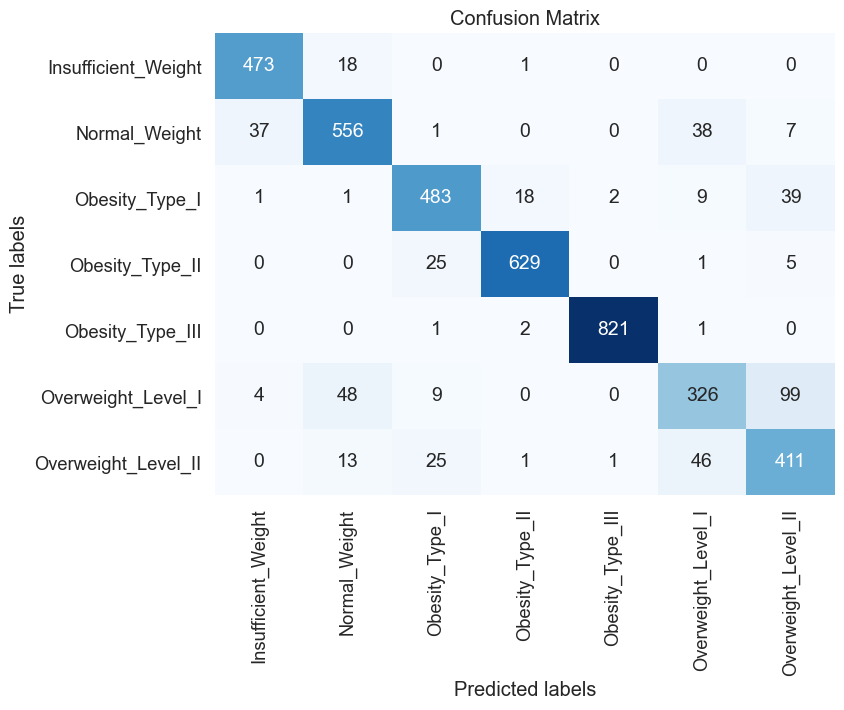

In [96]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
cr=classification_report(y_val,best_y_pred_log_val)
print(cr)
accuracy=accuracy_score(y_val,best_y_pred_log_val)
print('Accuracy is: ',accuracy)
cf=confusion_matrix(y_val,best_y_pred_log_val)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, cbar=False,xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Making predictions using logistic regression on test dataset

In [78]:
test_df_ohe['XGB']=le.transform(best_y_pred_xgbc_test)
test_df_ohe['LGBM']=le.transform(best_y_pred_lgbm_test)
test_df_ohe

id       Age    Height    Weight      FCVC       NCP      CH2O  \
0      20758  0.508163  1.682789  1.273786  0.932524  0.350808  1.298389   
1      20759 -0.509128 -1.114658 -0.818988 -0.833161 -2.462523  1.583678   
2      20760  0.353000 -0.626191  0.927432  1.047997  0.350808  0.965029   
3      20761 -0.512705 -1.642760  0.623672 -0.833161  0.319733  1.234234   
4      20762  0.353000 -0.805996  0.668336  1.047997  0.350808  1.016818   
...      ...       ...       ...       ...       ...       ...       ...   
13835  34593 -0.107749  0.252936 -0.358246  0.696661  0.350808 -1.688533   
13836  34594  0.870277 -1.227324 -0.972181  1.047997  0.350808 -0.052428   
13837  34595 -0.175379 -1.277495 -1.647125  1.047997 -0.670797 -0.052428   
13838  34596 -0.509128 -0.889324 -1.316865 -0.833161  0.350808 -0.052428   
13839  34597  0.437648  1.276794  1.286667  0.568291  0.350808  0.284573   

            FAF       TUE  Gender_Female  ...  CALC_Frequently  \
0     -0.141769 -1.005016          False  ...            False   
1      0.030307 -1.005016           True  ...            False   
2     -1.159701 -0.592995           True  ...            False   
3     -1.046828 -1.005016          False  ...            False   
4     -1.159701  0.213881           True  ...            False   
...         ...       ...            ...  ...              ...   
13835 -0.199274  0.275664          False  ...            False   
13836 -1.159701 -1.005016           True  ...            False   
13837  1.160623  0.639766           True  ...            False   
13838  2.410322  2.284548          False  ...            False   
13839  0.392415  0.032621          False  ...            False   

       CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0                True    False              False        False   
1                True    False              False        False   
2                True    False              False        False   
3                True    False              False        False   
4                True    False              False        False   
...               ...      ...                ...          ...   
13835            True    False              False        False   
13836            True    False              False        False   
13837            True    False              False        False   
13838           False     True              False        False   
13839            True    False              False        False   

       MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  XGB  \
0                 False                          True           False    3   
1                 False                          True           False    5   
2                 False                          True           False    4   
3                 False                          True           False    2   
4                 False                          True           False    4   
...                 ...                           ...             ...  ...   
13835             False                          True           False    6   
13836             False                          True           False    1   
13837             False                          True           False    0   
13838             False                          True           False    1   
13839             False                          True           False    3   

       LGBM  
0         3  
1         5  
2         4  
3         2  
4         4  
...     ...  
13835     6  
13836     5  
13837     0  
13838     1  
13839     3  

[13840 rows x 34 columns]

In [79]:
test_predproba_log=logreg.predict_proba(test_df_ohe.drop(columns=['id']))
best_y_pred_log_test = apply_thresholds(test_predproba_log, best_thresholds_log)
best_y_pred_log_test=le.inverse_transform(best_y_pred_log_test)
submission_log=test_df_ohe['id'].reset_index()
submission_log['NObeyesdad']=best_y_pred_log_test
submission_log=submission.set_index('id').drop(columns=['index'])
submission_log.to_csv('sub_log.csv')

In [80]:
accuracy_xgb=accuracy_score(y_val,xgbc.predict(X_val_ohe.drop(columns=['XGB','LGBM'])))

In [81]:
accuracy_xgb_probopt=accuracy_score(y_val,best_y_pred_xgbc_val)

In [82]:
accuracy_lgbm=accuracy_score(y_val,lgbm_c.predict(X_val_ohe.drop(columns=['XGB','LGBM'])))

[LightGBM] [Warning] Unknown parameter: class_weights
[LightGBM] [Warning] feature_fraction is set=0.9721415338635125, colsample_bytree=0.6620129953824786 will be ignored. Current value: feature_fraction=0.9721415338635125
[LightGBM] [Warning] lambda_l1 is set=0.0006736855911107503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006736855911107503
[LightGBM] [Warning] lambda_l2 is set=7.440526925966213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.440526925966213
[LightGBM] [Warning] bagging_fraction is set=0.4074895053692709, subsample=0.8301686394250093 will be ignored. Current value: bagging_fraction=0.4074895053692709
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [83]:
accuracy_lgm_probopt=accuracy_score(y_val,best_y_pred_lgbm_val)

In [84]:
accuracy_stacking=accuracy_score(y_val,best_y_pred_log_val)

In [85]:
accuracy_dict={'xgb':accuracy_xgb,'xgb_with_probopt':accuracy_xgb_probopt,'lgbm':accuracy_lgbm,'lgbm_with_probopt':accuracy_lgm_probopt,'stacking':accuracy_stacking}

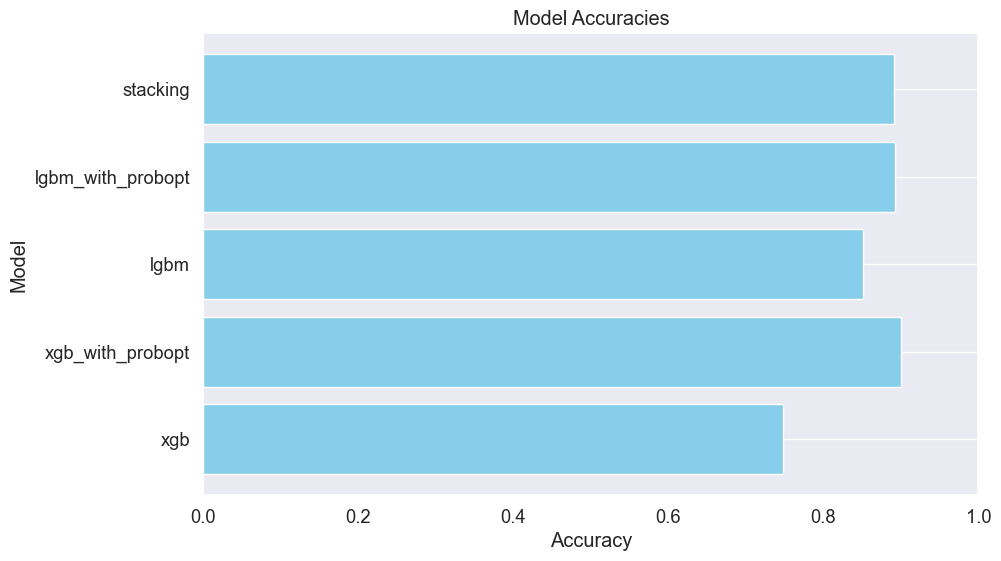

In [86]:
models = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())
kaggle_leaderboard_score=[0.854,0.897,0.864,0.895,0.899]
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracies')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1 for accuracy scale
plt.grid(axis='x')  # Add gridlines only on x-axis
plt.show()

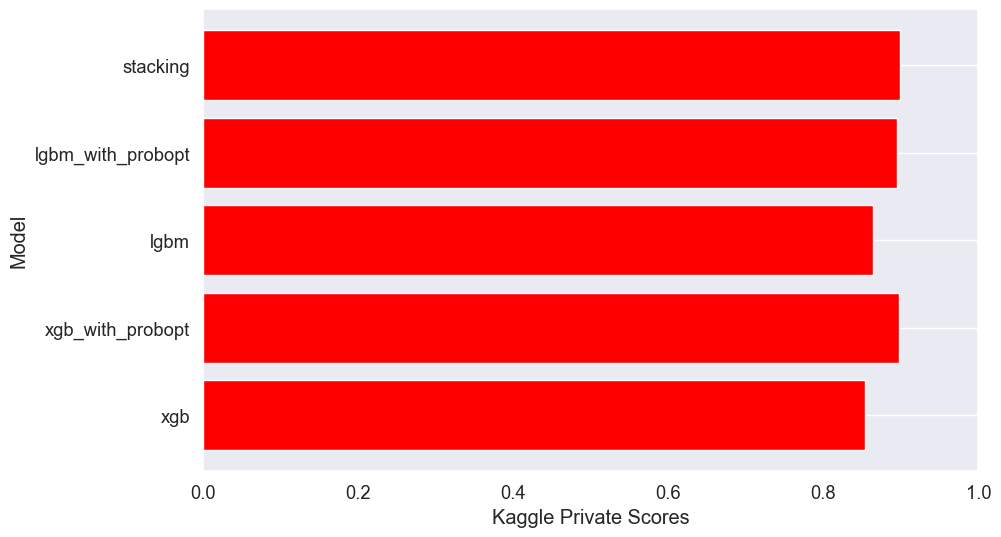

In [87]:
plt.figure(figsize=(10, 6))
plt.barh(models, kaggle_leaderboard_score, color='red')
plt.xlabel('Kaggle Private Scores')
plt.ylabel('Model')
#plt.title('Model Accuracies')
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1 for accuracy scale
plt.grid(axis='x')  # Add gridlines only on x-axis
plt.show()